In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# Cleaning and Combining Datasets

In [2]:
# Load the first dataset
df1 = pd.read_csv('badmintondata.csv')

# Load the second dataset
df2 = pd.read_csv('badmintondata2.csv')

# Combine both datasets
df_combined = pd.concat([df1, df2], ignore_index=True)

# Count rows before cleaning
rows_before_cleaning = df_combined.shape[0]

# Handling missing values
df_combined = df_combined.dropna()  # Drop rows with missing values

# Handling outliers (Using z-score)
z_scores_combined = (df_combined - df_combined.mean()) / df_combined.std()  # Calculate z-scores
threshold = 3  # Set a threshold for outliers
outliers_combined = (z_scores_combined.abs() > threshold).any(axis=1)  # Find rows with outliers
df_combined_cleaned = df_combined[~outliers_combined].copy()  # Filter out rows with outliers

# Identify consecutive rows of all zeros
mask = (df_combined == 0).all(axis=1)
groups = mask.cumsum()

# Filter out consecutive rows of all zeros
df_combined_cleaned = df_combined[~mask]
df_combined_cleaned.to_csv('cleaned_dataset.csv', index = False)

# Count rows after cleaning
rows_after_cleaning = df_combined_cleaned.shape[0]

print("Number of rows before cleaning:", rows_before_cleaning)
print("Number of rows after cleaning:", rows_after_cleaning)


Number of rows before cleaning: 315200
Number of rows after cleaning: 168842


# Generating Scatterplot of Cleaned Combined Dataset

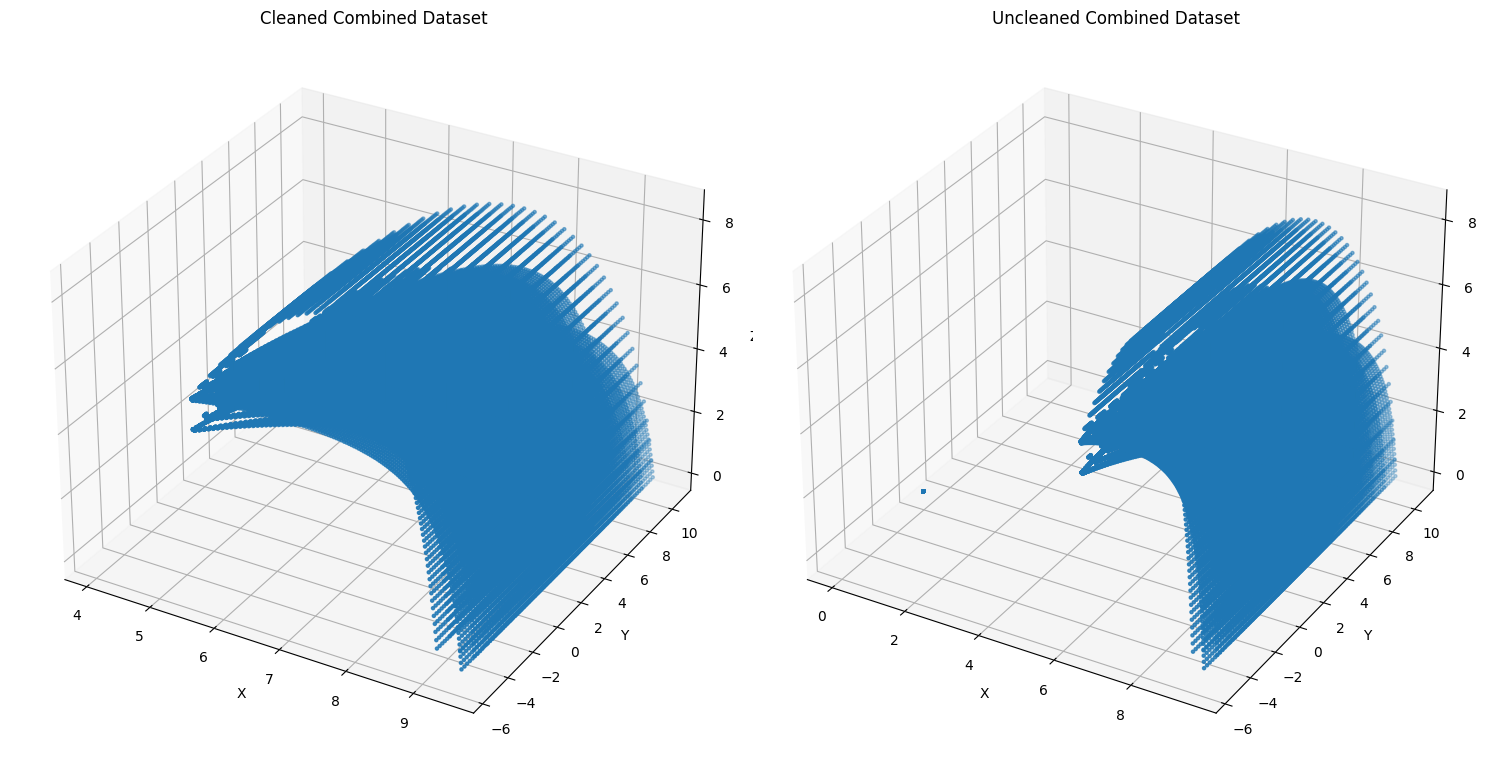

In [3]:
# Generate scatterplot for the cleaned combined dataset
fig, axes = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Cleaned Combined Dataset
axes[0].scatter(df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_zlabel('Z')
axes[0].set_title('Cleaned Combined Dataset')
axes[0].grid(True)

# Uncleaned Combined Dataset
axes[1].scatter(df_combined['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_zlabel('Z')
axes[1].set_title('Uncleaned Combined Dataset')
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Grouping the Data and Creating Training and Testing Sets

In [4]:
# Group the data before each group of zeros
grouped_df = df_combined_cleaned.groupby(groups, group_keys=False)

# Function to add a Time field and SERVE_ID to a group
def add_time_and_serve_id(group):
    group['TIME'] = np.arange(len(group)) * 10  # Multiply by 10 to get time in ms
    group['SERVE_ID'] = group.name  # Assign the group name as the SERVE_ID

    # Reset time to 0 at the start of each group
    group.loc[group.index[0], 'TIME'] = 0
    
    return group

# Apply a TIME-based transformation and add SERVE_ID to each group
grouped_df = grouped_df.apply(add_time_and_serve_id)

# Extract unique groups
serve_ids = grouped_df['SERVE_ID'].unique()

# Drop duplicated groups
serve_ids = np.unique(serve_ids)

# Split the groups into testing set and sample set (split into a testing set and a sample set using a 70:30 ratio)
train_groups, test_groups = train_test_split(serve_ids, test_size=0.3, random_state=42)

# Create the training set with highest point labels
train_data = []
for group in train_groups:
    group_data = grouped_df[grouped_df['SERVE_ID'] == group].copy()
    highest_point = group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'].max()
    group_data['HIGHEST_POINT'] = highest_point
    train_data.append(group_data)

train_df = pd.concat(train_data)

# Create the testing set with highest point labels
test_data = []
for group in test_groups:
    group_data = grouped_df[grouped_df['SERVE_ID'] == group].copy()
    highest_point = group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'].max()
    group_data['HIGHEST_POINT'] = highest_point
    test_data.append(group_data)

test_df = pd.concat(test_data)

grouped_df

,HUMAN PLAYER POSITION (X) metres,HUMAN PLAYER POSITION (Y) metres,INITITAL VELOCITY OF SHUTTELCOCK(m/s),INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE),SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE),SHUTTLECOCK POSITIION IN AIR(X) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,TIME,SERVE_ID
0,4,1,10,40,0,4.075543,1.000000,1.662912,0,0
1,4,1,10,40,0,4.152007,1.000000,1.724866,10,0
2,4,1,10,40,0,4.228906,1.000000,1.788139,20,0
3,4,1,10,40,0,4.302100,1.000000,1.845245,30,0
4,4,1,10,40,0,4.376877,1.000000,1.904128,40,0
...,...,...,...,...,...,...,...,...,...,...
315035,4,4,70,70,50,9.276323,10.288077,3.041504,350,146198
315036,4,4,70,70,50,9.326762,10.348188,2.466079,360,146198
315037,4,4,70,70,50,9.373273,10.403617,1.861569,370,146198
315038,4,4,70,70,50,9.414002,10.452156,1.230060,380,146198


In [5]:
# Duplicate grouped_df and store it in grouped_df_copy
grouped_df_copy = grouped_df.copy()

# Select the first row of each group
first_rows = grouped_df_copy.groupby(groups).first()

# Specify the columns to include in the CSV
columns_to_export = ['HUMAN PLAYER POSITION (X) metres',
                     'HUMAN PLAYER POSITION (Y) metres',
                     'INITITAL VELOCITY OF SHUTTELCOCK(m/s)',
                     'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)',
                     'SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                     'SHUTTLECOCK POSITIION IN AIR(X) metres',
                     'SHUTTLECOCK POSITIION IN AIR(Y) metres',
                     'SHUTTLECOCK POSITIION IN AIR(Z) metres',
                     'TIME',
                     'SERVE_ID']

# Export the first rows of each group to a CSV file
first_rows.to_csv('group_serveID.csv', columns=columns_to_export, header=True, index=False)

print("Data saved to group_serveID.csv")
print(grouped_df)

Data saved to group_serveID.csv
        HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
0                                      4                                 1   
1                                      4                                 1   
2                                      4                                 1   
3                                      4                                 1   
4                                      4                                 1   
...                                  ...                               ...   
315035                                 4                                 4   
315036                                 4                                 4   
315037                                 4                                 4   
315038                                 4                                 4   
315039                                 4                                 4   

        INITITAL VELOCITY OF SH

# (Retired model) Training and Evaluating a Regression Model based on Shuttlecock positions and Highest point


In [6]:
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.model_selection import cross_val_score
# import joblib

# # Separate the features and target variable in the training set
# X_train = train_df[["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres", "SHUTTLECOCK POSITIION IN AIR(Z) metres"]]
# y_train = train_df['HIGHEST_POINT']

# print("Training the model...")
# # Train the model
# model = RandomForestRegressor()
# model.fit(X_train, y_train)
# print("Model training complete.")

# # Separate the features and target variable in the testing set
# X_test = test_df[["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres", "SHUTTLECOCK POSITIION IN AIR(Z) metres"]]
# y_test = test_df['HIGHEST_POINT']

# print("Making predictions on the testing set...")
# # Make predictions on the testing set
# y_coordinates = model.predict(X_test)
# print("Prediction complete.")

# # Calculate performance indicators
# r2 = model.score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_coordinates))
# mae = mean_absolute_error(y_test, y_coordinates)
# cv_rmse = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))

# print("Performance Indicators:")
# print(f"R^2: {r2}")
# print(f"RMSE: {rmse}")
# print(f"MAE: {mae}")
# print(f"CV RMSE: {cv_rmse}")

# # Export the model
# joblib.dump(model, 'regression_model.joblib')
# print("Model saved as regression_model.joblib.")

# (New model) Training and Evaluating a Regression Model based on input features such as human coordinates, and initial shuttlecock values. Output features being the coordinates of the shuttlecock

In [7]:
# Separate the features and target variable in the training set
X_train = train_df[["HUMAN PLAYER POSITION (X) metres", "HUMAN PLAYER POSITION (Y) metres", "INITITAL VELOCITY OF SHUTTELCOCK(m/s)", "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)", "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)", "TIME"]]
y_train = train_df[["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres", "SHUTTLECOCK POSITIION IN AIR(Z) metres"]]

print("Training the model...")
# Train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)
print("Model training complete.")

# Separate the features and target variable in the testing set
X_test = test_df[["HUMAN PLAYER POSITION (X) metres", "HUMAN PLAYER POSITION (Y) metres", "INITITAL VELOCITY OF SHUTTELCOCK(m/s)", "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)", "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","TIME"]]
y_test = test_df[["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres", "SHUTTLECOCK POSITIION IN AIR(Z) metres"]]

print("Making predictions on the testing set...")
# Make predictions on the testing set
y_coordinates = model.predict(X_test)
print("Prediction complete.")

# Calculate performance indicators
r2 = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_coordinates))
mae = mean_absolute_error(y_test, y_coordinates)
cv_rmse = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))

print("Performance Indicators:")
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"CV RMSE: {cv_rmse}")

# Export the model
joblib.dump(model, 'regression_model.joblib')
print("Model saved as regression_model.joblib.")

Training the model...
Model training complete.
Making predictions on the testing set...
Prediction complete.
Performance Indicators:
R^2: 0.9602696458449526
RMSE: 0.3329313644741057
MAE: 0.14309485084772042
CV RMSE: 0.2227959036691997
Model saved as regression_model.joblib.


# Performance indicators for your regression model

R^2: Good (High)
RMSE: Good (Low)
MAE: Good (Low)
CV RMSE: Good (Low)


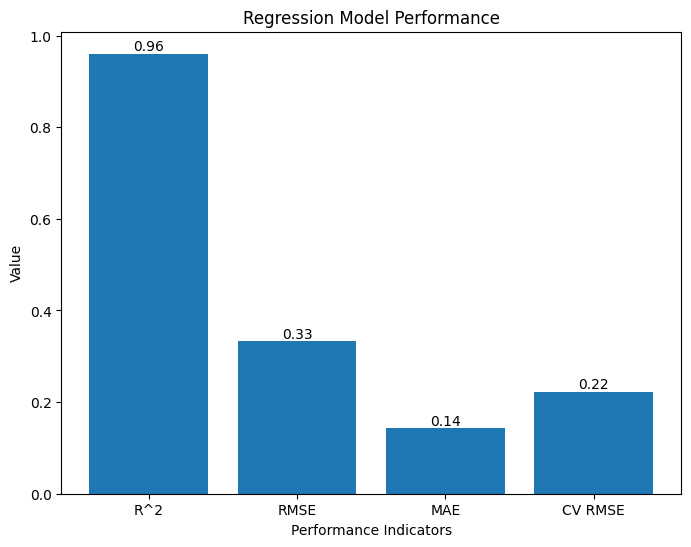

In [8]:
import matplotlib.pyplot as plt

# Create a bar plot for the performance indicators
indicators = ['R^2', 'RMSE', 'MAE', 'CV RMSE']
values = [r2, rmse, mae, cv_rmse]

plt.figure(figsize=(8, 6))
plt.bar(indicators, values)
plt.xlabel('Performance Indicators')
plt.ylabel('Value')
plt.title('Regression Model Performance')

# Add values on top of each bar
for i, v in enumerate(values):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')
    
    # Print statement indicating good or bad, high or low
    if indicators[i] == 'R^2':
        if v >= 0.7:
            print('R^2: Good (High)')
        elif v >= 0.5:
            print('R^2: Acceptable (Medium)')
        else:
            print('R^2: Poor (Low)')
    elif indicators[i] == 'RMSE':
        if v <= 10:
            print('RMSE: Good (Low)')
        elif v <= 50:
            print('RMSE: Acceptable (Medium)')
        else:
            print('RMSE: Poor (High)')
    elif indicators[i] == 'MAE':
        if v <= 5:
            print('MAE: Good (Low)')
        elif v <= 10:
            print('MAE: Acceptable (Medium)')
        else:
            print('MAE: Poor (High)')
    elif indicators[i] == 'CV RMSE':
        if v <= 15:
            print('CV RMSE: Good (Low)')
        elif v <= 30:
            print('CV RMSE: Acceptable (Medium)')
        else:
            print('CV RMSE: Poor (High)')

plt.show()


# Created an ArrayList of predicted position coordinates with timestamp (predefined input x features), and another ArrayList of actual position coordinates with timestamp (taken from the same exact features from grouped_df's serve 0 which has the same values)


The code predicts and compares the positions of a badminton serve. It uses a regression model to make predictions based on various input features. The code iteratively predicts the positions until the height (z-coordinate) falls below 1.14 cm, considering that the badminton height combined with the robot's height is 120 cm. Since the top quarter of the badminton has a height of 60 mm (6 cm), the robot needs to hit the shuttlecock above 1.14 cm to avoid issues. The predicted positions, along with their timestamps, are stored in the predicted_positions list. The code also retrieves the actual positions from a DataFrame and stores them in the actual_positions list. The x, y, and z coordinates of both the predicted and actual positions are extracted for further analysis.

In [9]:
import joblib
import numpy as np
import pandas as pd

# Load the saved model
model = joblib.load('regression_model.joblib')

# Load the CSV file
grouped_df_copy = pd.read_csv('group_serveID.csv')

# Select a random row from the DataFrame
random_row = grouped_df_copy.sample(n=1)

# Extract the values from the random row
human_x = random_row['HUMAN PLAYER POSITION (X) metres'].values[0]
human_y = random_row['HUMAN PLAYER POSITION (Y) metres'].values[0]
initial_velocity = random_row['INITITAL VELOCITY OF SHUTTELCOCK(m/s)'].values[0]
initial_firing_angle = random_row['INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'].values[0]
slant_angle = random_row['SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'].values[0]
time = random_row['TIME'].values[0]
serve_id = random_row['SERVE_ID'].values[0]

print("Selected Random Row:")
print(random_row)

print("\nInitial Parameters:")
print("Human Player Position (X):", human_x)
print("Human Player Position (Y):", human_y)
print("Initial Velocity of Shuttlecock:", initial_velocity)
print("Initial Shuttlecock Firing Angle:", initial_firing_angle)
print("Shuttlecock Slant Angle to Sideline:", slant_angle)
print("Time:", time)
print("Serve ID:", serve_id)

# Create an empty list to store the predicted positions with timestamps
predicted_positions = []

print("\nPredicting and appending...")

while True:
    # Create the input feature for prediction
    sample_test = [[human_x, human_y, initial_velocity, initial_firing_angle, slant_angle, time]]

    # Make the prediction
    predicted_position = model.predict(sample_test)[0]  # [0] to extract the array from the list

    # Append the predicted position with the current time
    timestamp = np.append(predicted_position, time)
    predicted_positions.append(timestamp)

    # Update the time
    time += 10

    # Check if the cutoff height is reached
    if predicted_position[2] <= 1.14:  # [2] to extract the z coordinate
        print("Cutoff height reached. Stopping predictions.")
        break

print("\nPredictions completed with cutoff height.")

# Extract x, y, z coordinates from the predicted positions
pred_x_coordinates = [position[0] for position in predicted_positions]
pred_y_coordinates = [position[1] for position in predicted_positions]
pred_z_coordinates = [position[2] for position in predicted_positions]

print(pred_x_coordinates)
# Create an empty list to store actual positions with timestamps
actual_positions = []

# Filter rows based on 'SERVE_ID' equal to serve_id from the random row
serve_output = grouped_df[grouped_df['SERVE_ID'] == serve_id]

print("\nFiltering rows...")
print("Filtered rows:")

# Iterate over the filtered rows
for i, row in serve_output.iterrows():
    x = row["SHUTTLECOCK POSITIION IN AIR(X) metres"]
    y = row["SHUTTLECOCK POSITIION IN AIR(Y) metres"]
    z = row["SHUTTLECOCK POSITIION IN AIR(Z) metres"]
    time = row["TIME"]
    timestamped = (x, y, z, time)  # Append individual positions and the current time
    actual_positions.append(timestamped)

# Extract x, y, z coordinates from the actual positions
actual_x_coordinates = [position[0] for position in actual_positions]
actual_y_coordinates = [position[1] for position in actual_positions]
actual_z_coordinates = [position[2] for position in actual_positions]


Selected Random Row:
   HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
7                                 4                                 1   

   INITITAL VELOCITY OF SHUTTELCOCK(m/s)  \
7                                     10   

   INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)  \
7                                         40   

   SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  \
7                                            7   

   SHUTTLECOCK POSITIION IN AIR(X) metres  \
7                                4.075799   

   SHUTTLECOCK POSITIION IN AIR(Y) metres  \
7                                1.009307   

   SHUTTLECOCK POSITIION IN AIR(Z) metres  TIME  SERVE_ID  
7                                1.664019     0       546  

Initial Parameters:
Human Player Position (X): 4
Human Player Position (Y): 1
Initial Velocity of Shuttlecock: 10
Initial Shuttlecock Firing Angle: 40
Shuttlecock Slant Angle to Sideline: 7
Time: 0
Serve ID: 546

Predicting and appending...
C

# Badminton Court Using Python Matplotlib Module

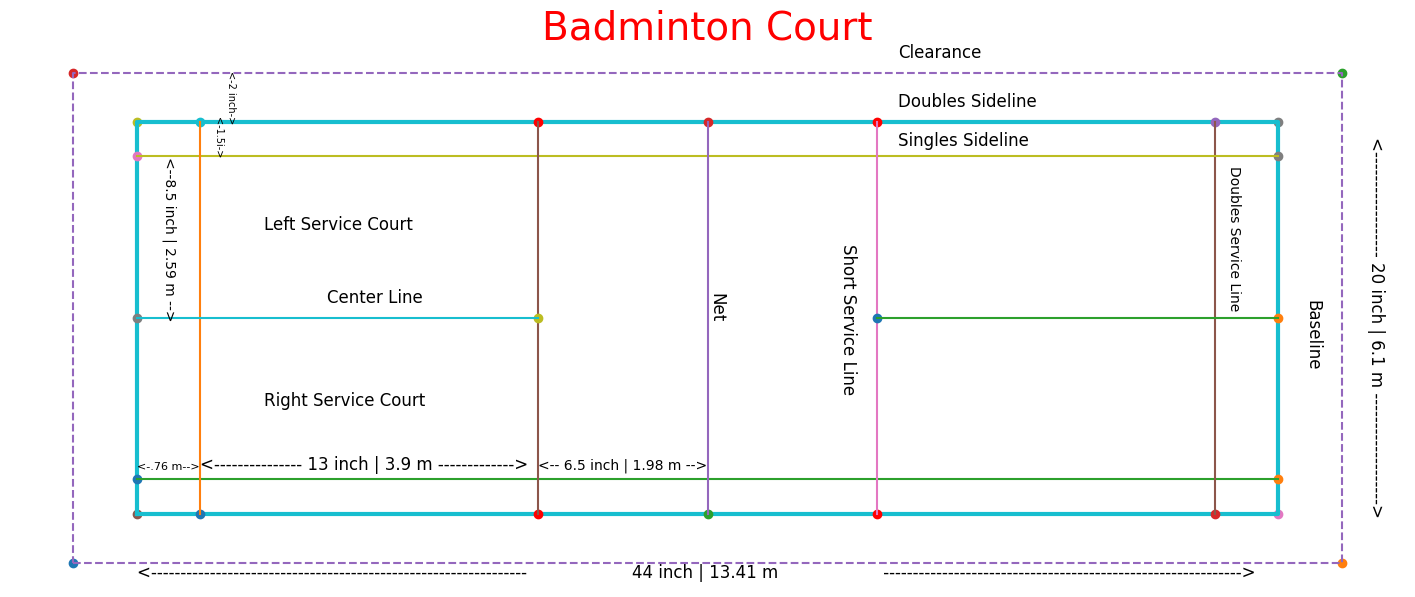

In [10]:
plt.figure(figsize = (18, 7))
#points for clearance area
plt.plot(1.5, 1.5, marker = 'o')
plt.plot(11.5, 1.5, marker = 'o')
plt.plot(11.5, 11.5, marker = 'o')
plt.plot(1.5, 11.5, marker = 'o')
plt.gca().annotate('Clearance', xy=(8, 11.8), xycoords='data', fontsize=12)
#draw line in clearance area
plt.plot([1.5, 11.5, 11.5, 1.5, 1.5], [1.5, 1.5, 11.5, 11.5, 1.5],linestyle = 'dashed')
#draw points for doubles sideline
plt.plot(2, 2.5, marker = 'o')
plt.plot(11, 2.5, marker = 'o')
plt.plot(11, 10.5, marker = 'o')
plt.plot(2, 10.5, marker = 'o')
#draw line in doubles sideline area
plt.plot([2, 11, 11, 2, 2], [2.5, 2.5, 10.5, 10.5, 2.5],linestyle = 'solid', linewidth = 3)
plt.gca().annotate('Doubles Sideline', xy=(8, 10.8), xycoords='data', fontsize=12)
plt.gca().annotate('Baseline', xy=(11.2, 5.5), xycoords='data', fontsize=12, rotation=270)
plt.gca().annotate('<-2 inch->', xy=(2.7, 10.5), xycoords='data', fontsize=7, rotation=270)
plt.gca().annotate('<---------------------------------------------------------------- \
                   44 inch | 13.41 m \
                   ------------------------------------------------------------->', xy=(2, 1.2), xycoords='data', fontsize=12)
plt.gca().annotate('<------------------ 20 inch | 6.1 m ------------------->', xy=(11.7, 2.5), xycoords='data', fontsize=12, rotation=270)
#draw bottom points for singles sideline
plt.plot(2, 3.2, marker = 'o')
plt.plot(11, 3.2, marker = 'o')
plt.plot([2, 11], [3.2, 3.2])
#draw right points for singles sideline
plt.plot(10.5, 2.5, marker = 'o')
plt.plot(10.5, 10.5, marker = 'o')
plt.plot([10.5, 10.5], [2.5, 10.5])
#draw top points for singles sideline
plt.plot(2, 9.8, marker = 'o')
plt.plot(11, 9.8, marker = 'o')
plt.plot([2, 11], [9.8, 9.8])
#draw left points for singles sideline
plt.plot(2.5, 10.5, marker = 'o')
plt.plot(2.5, 2.5, marker = 'o')
plt.plot([2.5, 2.5], [10.5, 2.5])
plt.gca().annotate('Singles Sideline', xy=(8, 10), xycoords='data', fontsize=12)
plt.gca().annotate('<-1.5i->', xy=(2.6, 9.8), xycoords='data', fontsize=7, rotation=270)
#net points
#take the middle of doubles sideline bottom points  
x = (2 + 11)/2
#print(x)
plt.plot(x, 2.5, marker = 'o')
plt.plot(x, 10.5, marker = 'o')
plt.plot([x, x], [2.5, 10.5])
plt.gca().annotate('Net', xy=(x, 6.5), xycoords='data', fontsize=12, rotation=270)
#left short service line
# point will start from single sideline to net. Then divide into 3 parts.
x1 = (x - 2.5)/3 
#print(x1)
x2 = 6.5 - x1
plt.plot(x2, 2.5, marker = 'o', color = 'red')
plt.plot(x2, 10.5, marker = 'o', color = 'red')
plt.plot([x2, x2], [2.5, 10.5])
#right short service line
x3 = 6.5 + x1
plt.plot(x3, 2.5, marker = 'o', color = 'red')
plt.plot(x3, 10.5, marker = 'o', color = 'red')
plt.plot([x3, x3], [2.5, 10.5])
plt.gca().annotate('Short Service Line', xy=(x3 - 0.3, 5), xycoords='data', fontsize=12, rotation=270)
plt.gca().annotate('<-.76 m-->', xy=(2, 3.4), xycoords='data', fontsize=8)
plt.gca().annotate('<--------------- 13 inch | 3.9 m ------------->', xy=(2.5, 3.4), xycoords='data', fontsize=12)
plt.gca().annotate('<-- 6.5 inch | 1.98 m -->', xy=(x2, 3.4), xycoords='data', fontsize=10)
#draw points for left center line
y1 = (2.5 + 10.5)/2
plt.plot(2, y1, marker = 'o')
plt.plot(x2, y1, marker = 'o')
plt.plot([2, x2], [y1, y1])
plt.gca().annotate('Left Service Court', xy=(3, y1 + 1.8), xycoords='data', fontsize=12)
plt.gca().annotate('Center Line', xy=(3.5, y1 + .3), xycoords='data', fontsize=12)
plt.gca().annotate('Right Service Court', xy=(3, y1 - 1.8), xycoords='data', fontsize=12)
plt.gca().annotate('<--8.5 inch | 2.59 m -->', xy=(2.2, y1), xycoords='data', fontsize=10, rotation=270)
#draw points for right center line
plt.plot(x3, y1, marker = 'o')
plt.plot(11, y1, marker = 'o')
plt.plot([x3, 11], [y1, y1])
plt.gca().annotate('Doubles Service Line', xy=(10.6, 6.7), xycoords='data', fontsize=10, rotation=270)
plt.xlim(1, 12)
plt.ylim(1, 12)
plt.title("Badminton Court", fontsize=28, color = 'red')
plt.axis("off")
plt.show()

# Badminton Court Using Python plotly Module (3D)

In [11]:
import plotly.graph_objects as go

fig = go.Figure()

# Add the badminton court lines in 3D with colors
fig.add_trace(go.Scatter3d(
    x=[1.5, 11.5, 11.5, 1.5, 1.5],
    y=[1.5, 1.5, 11.5, 11.5, 1.5],
    z=[0, 0, 0, 0, 0],
    mode='lines',
    line=dict(color='black', width=5),
    hovertext=['court line'],
    name='court line'
))

fig.add_trace(go.Scatter3d(
    x=[2, 11, 11, 2, 2],
    y=[2.5, 2.5, 10.5, 10.5, 2.5],
    z=[0, 0, 0, 0, 0],
    mode='lines',
    line=dict(color='blue', width=3),
    hovertext=['doubles sideline'],
    name='doubles sideline'
))

fig.add_trace(go.Scatter3d(
    x=[2, 11],
    y=[3.2, 3.2],
    z=[0, 0],
    mode='lines',
    line=dict(color='green'),
    hovertext=['singles sideline'],
    name='singles sideline'
))

fig.add_trace(go.Scatter3d(
    x=[10.5, 10.5],
    y=[2.5, 10.5],
    z=[0, 0],
    mode='lines',
    line=dict(color='green'),
    hovertext=['singles sideline'],
    name='singles sideline'
))

fig.add_trace(go.Scatter3d(
    x=[2, 11],
    y=[9.8, 9.8],
    z=[0, 0],
    mode='lines',
    line=dict(color='green'),
    hovertext=['singles sideline'],
    name='singles sideline'
))

fig.add_trace(go.Scatter3d(
    x=[2.5, 2.5],
    y=[2.5, 10.5],
    z=[0, 0],
    mode='lines',
    line=dict(color='green'),
    hovertext=['singles sideline'],
    name='singles sideline'
))

# Add the net in 3D with colors
fig.add_trace(go.Scatter3d(
    x=[(2 + 11) / 2, (2 + 11) / 2],
    y=[2.5, 10.5],
    z=[0, 0],
    mode='lines',
    line=dict(color='red'),
    hovertext=['net'],
    name='net'
))

fig.add_trace(go.Scatter3d(
    x=[(2 + 11) / 2],
    y=[6.5],
    z=[0],
    mode='markers',
    marker=dict(size=5, color='red'),
    hovertext=['net'],
    hoverinfo='text',
    name='net'
))

# Add the short service lines in 3D with colors
fig.add_trace(go.Scatter3d(
    x=[(2 + 11) / 2 - 0.76, (2 + 11) / 2 - 0.76],
    y=[2.5, 10.5],
    z=[0, 0],
    mode='lines',
    line=dict(color='yellow'),
    hovertext=['short service line'],
    name='short service line'
))

fig.add_trace(go.Scatter3d(
    x=[(2 + 11) / 2 + 0.76, (2 + 11) / 2 + 0.76],
    y=[2.5, 10.5],
    z=[0, 0],
    mode='lines',
    line=dict(color='yellow'),
    hovertext=['short service line'],
    name='short service line'
))

fig.add_trace(go.Scatter3d(
    x=[(2 + 11) / 2 - 0.76, (2 + 11) / 2 + 0.76],
    y=[2.5, 2.5],
    z=[0, 0],
    mode='lines',
    line=dict(color='yellow'),
    hovertext=['short service line'],
    name='short service line'
))

fig.add_trace(go.Scatter3d(
    x=[(2 + 11) / 2 - 0.76, (2 + 11) / 2 + 0.76],
    y=[10.5, 10.5],
    z=[0, 0],
    mode='lines',
    line=dict(color='yellow'),
    hovertext=['short service line'],
    name='short service line'
))

# Set the layout of the figure
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[0, 13.4], title='X'),
        yaxis=dict(range=[0, 13.4], title='Y'),
        zaxis=dict(range=[0, 1], title='Z')
    ),
    title='3D Visualization of Badminton Court',
)

# Show the figure
fig.show()


# Plotting of both trajectories for Data Visualisation, & Court lines 

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

# Net parameters
net_height = 1.524  # Net height in meters
net_width = 5.18  # Net width in meters
num_horizontal_lines = 4  # Number of horizontal lines in the net
num_vertical_lines = 4  # Number of vertical lines in the net

# Add the predicted trajectory
print("Adding predicted trajectory...")
fig.add_trace(go.Scatter3d(
    x=pred_x_coordinates,
    y=pred_y_coordinates,
    z=pred_z_coordinates,
    mode='lines',
    marker=dict(size=5),
    line=dict(color='green'),
    hovertext=['predicted trajectory'],
    name='predicted trajectory'
))

# Add the actual trajectory line
print("Adding actual trajectory...")
fig.add_trace(go.Scatter3d(
    x=actual_x_coordinates,
    y=actual_y_coordinates,
    z=actual_z_coordinates,
    mode='lines',
    marker=dict(size=5),
    line=dict(color='red'),
    hovertext=['actual trajectory'],
    name='actual trajectory'
))

# Add markers for highest point and predicted point
print("Adding markers...")
max_z_index = actual_z_coordinates.index(max(actual_z_coordinates))
marker_data = [
    (actual_x_coordinates[max_z_index], actual_y_coordinates[max_z_index], actual_z_coordinates[max_z_index], 'Highest Point', 'blue'),
    (pred_x_coordinates[-1], pred_y_coordinates[-1], pred_z_coordinates[-1], 'Predicted Point of Robot\'s Shot', 'orange'),
    (actual_x_coordinates[0], actual_y_coordinates[0], actual_z_coordinates[0], 'Shuttlecock Starting Position', 'purple')
]

for x, y, z, text, color in marker_data:
    fig.add_trace(go.Scatter3d(
        x=[x],
        y=[y],
        z=[z],
        mode='markers',
        marker=dict(size=5, color=color),
        hovertext=[text],
        hoverinfo='text',
        name=text
    ))

# Add lines for net, court, and service lines
print("Adding lines...")
line_data = [
    ([13.4/2, 13.4/2], [i * net_width / (num_horizontal_lines - 1), (i + 1) * net_width / (num_horizontal_lines - 1)], [net_height, net_height], 'red', 2, 'dot') for i in range(num_horizontal_lines)
] + [
    ([13.4/2, 13.4/2], [i * net_width / (num_vertical_lines - 1)] * 2, [0, net_height], 'red', 2, 'dot') for i in range(num_vertical_lines)
]

line_data += [
    ([0, 13.4, 13.4, 0, 0], [0, 0, 5.18, 5.18, 0], [0, 0, 0, 0, 0], 'black', 5, None),
    ([13.4/2, 13.4/2], [0, 5.18], [0, 0], 'green', 4, 'dash'),
    ([13.4/2 - 1.98, 13.4/2 + 1.98, 13.4/2 + 1.98, 13.4/2 - 1.98, 13.4/2 - 1.98], [0, 0, 5.18, 5.18, 0], [0, 0, 0, 0, 0], 'black', 2, None),
    ([0.72, 0.72], [0, 5.18], [0, 0], 'black', 2, None),
    ([13.4-0.72, 13.4-0.72], [0, 5.18], [0, 0], 'black', 2, None)
]

for x, y, z, color, width, dash in line_data:
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color, width=width, dash=dash),
        hovertext=['net' if color == 'red' else 'court line'],
        name='net' if color == 'red' else 'court line'
    ))

# Set the layout of the figure
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[0, 13.4], title='X'),
        yaxis=dict(range=[0, 5.18], title='Y'),
        zaxis=dict(range=[0, max(actual_z_coordinates)+1], title='Z')
    ),
    title='Data Visualization of Trajectories of Shuttlecock and Robot\'s Shot',
)

# Show the figure
print("Displaying the figure...")
fig.show()


Adding predicted trajectory...
Adding actual trajectory...
Adding markers...
Adding lines...
Displaying the figure...


# Calculation of Robot's possibility to reach the predicted point in time

The robot is initialized with a random starting position within a given range. It calculates the distance between its starting position and the first point in a trajectory. Based on this distance and the constraints of the court, it determines the maximum distance the robot can move towards the first point. The time required to reach the first point is calculated based on the maximum distance. The code then checks if this time is within the timing of the highest point in the actual trajectory. If it is, the robot moves towards the first point. Otherwise, it calculates the remaining time and moves towards a predicted position based on the coordinates of the last point in the prediction. The code determines if the robot is able to reach the predicted shot point based on the calculated maximum distance. 

The value 4.24 is derived from the Pythagorean theorem. In the badminton court, the x-axis represents a distance of 3 meters, and the y-axis also represents a distance of 3 meters. If we consider the court as a square with sides of 3 meters, the diagonal of this square (which represents the maximum distance the robot can move) can be calculated using the Pythagorean theorem: sqrt(3^2 + 3^2) = sqrt(18) ≈ 4.24. Therefore, the maximum distance the robot can move in any direction within the court is approximately 4.24 meters.

Regarding the value 1500, it represents the time interval in milliseconds between each recorded position of the shuttlecock. In the code, it is used to convert the distance the robot can move (which is calculated in meters) to the corresponding time it takes to cover that distance. The formula (max_distance_to_move / 4.24) * 1500 calculates the time it takes for the robot to move a certain distance based on the assumption that it moves at a constant speed of 4.24 meters per second. By multiplying the distance by (1 / 4.24) * 1500, we convert the distance to the corresponding time in milliseconds.

In [13]:
import random
import math
import plotly.graph_objects as go

# Robot class
class Robot:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.z = 0

    def move(self, dx, dy):
        self.x += dx
        self.y += dy

    def distance_to_point(self, x, y):
        return math.sqrt((self.x - x) ** 2 + (self.y - y) ** 2)


# Generate a random starting position within the given range 
robot_x_initial = random.randint(9, 12)  # x-coordinate range: (8.68, 13.4) within the court
robot_y_initial = random.randint(0, 5)  # y-coordinate range: (0, 5.15) within the court

# Initialize the robot with the random starting position
robot = Robot(robot_x_initial, robot_y_initial)

# Calculate the Euclidean distance from the robot's current position to the first point in `actual_positions_list`
distance_to_first_point = robot.distance_to_point(actual_positions[0][0], actual_positions[0][1])

# Calculate the maximum distance the robot can move towards the first point within the given constraints
max_distance_to_move = min(distance_to_first_point, 5 - robot_y_initial)  # Limit y-coordinate to stay within the robot's half of the court

# Calculate the time (in milliseconds) it takes for the robot to move towards the first point
time_to_reach_first_point = (max_distance_to_move / 4.24) * 1500  # 4.24 is the max distance calculated with Pythagoras theorem 

# Get the timestamp of the highest position of the actual trajectory
highest_position_timestamp = actual_positions[max_z_index][-1]

# Initialize the variable `max_distance_to_move_predicted`
max_distance_to_move_predicted = 0

# Check if the time to reach the first point is within the timing of highest_position_timestamp
if time_to_reach_first_point <= highest_position_timestamp:
    # Move the robot towards the first point within the given constraints
    robot.move(0, max_distance_to_move)
else:
    # Calculate the remaining time after reaching the highest point
    remaining_time = time_to_reach_first_point - highest_position_timestamp

    # Move the robot towards the predicted position based on the coordinates `(x_coordinates[-1], y_coordinates[-1])`
    distance_to_predicted_position = robot.distance_to_point(pred_x_coordinates[-1], pred_y_coordinates[-1])
    max_distance_to_move_predicted = min(distance_to_predicted_position, remaining_time * 4.2426406871193 / 1500)
    dx = (pred_x_coordinates[-1] - robot.x) * (max_distance_to_move_predicted / distance_to_predicted_position)
    dy = (pred_y_coordinates[-1] - robot.y) * (max_distance_to_move_predicted / distance_to_predicted_position)
    robot.move(dx, dy)

# Get the timestamp of the predicted position's last point
predicted_position_timestamp = predicted_positions[-1][-1]

# Calculate the time difference (in milliseconds)
time_highest_to_predicted = predicted_position_timestamp - highest_position_timestamp

# Print the robot's starting position
print("Robot's starting position (x,y): ", robot_x_initial, robot_y_initial, "\n")

# Print the initial shuttlecock's position
print("Shuttlecock's initial position (x,y,z): ", actual_x_coordinates[0], actual_y_coordinates[0], actual_z_coordinates[0], "\n")

# Print shuttlecock's highest position
print("Shuttlecock's highest position (x,y,z): ", actual_x_coordinates[max_z_index], actual_y_coordinates[max_z_index], actual_z_coordinates[max_z_index], "\n")

# Print the predicted shuttlecock's position
print("Shuttlecock's predicted position (x,y,z): ", pred_x_coordinates[-1], pred_y_coordinates[-1], pred_z_coordinates[-1], "\n")

print("Time needed to go to predicted position:", max_distance_to_move_predicted, "ms", "\n")

if max_distance_to_move_predicted < time_highest_to_predicted:
    print("Robot is able to reach the predicted shot point")

else:
    print("Robot is unable to reach the predicted shot point")

# Print the robot's final position
print("Robot's final position (x,y): ", pred_x_coordinates[-1], pred_y_coordinates[-1], "\n")

# Robot's initial position
fig.add_trace(
    go.Scatter3d(
        x=[robot_x_initial],
        y=[robot_y_initial],
        z=[0],
        mode='markers',
        line=dict(color='black', width=2),
        hovertext=['Robot Initial Position'],
        name='Robot Initial Position'
    )
)

# Robot's final position
fig.add_trace(
    go.Scatter3d(
        x=[pred_x_coordinates[-1]],
        y=[pred_y_coordinates[-1]],
        z=[0],
        mode='markers',
        line=dict(color='pink', width=2),
        hovertext=['Robot Final Position'],
        name='Robot Final Position'
    )
)

fig.show()


Robot's starting position (x,y):  11 3 

Shuttlecock's initial position (x,y,z):  4.075799124 1.009306962 1.664018978 

Shuttlecock's highest position (x,y,z):  7.906446061 1.479651264 3.708716706 

Shuttlecock's predicted position (x,y,z):  9.375928448434006 1.659130237145666 1.1149610781743335 

Time needed to go to predicted position: 0.16276797604671517 ms 

Robot is able to reach the predicted shot point
Robot's final position (x,y):  9.375928448434006 1.659130237145666 



# Hyperparameter Tuning 
Experiment with different hyperparameters of the RandomForestRegressor to find the combination that yields better performance. You can use techniques like grid search or random search to explore the hyperparameter space and find optimal values. Adjusting parameters such as the number of estimators, max depth, or min samples leaf can significantly impact the model's accuracy.

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 500),      # Number of trees in the forest
    'max_depth': [None] + list(range(5, 15)),  # Maximum depth of each tree
    'min_samples_split': randint(2, 20)     # Minimum number of samples required to split a node
}

tuning = 1
best_model_error_margin = float('inf')
best_params = {}

while True:

    print(f'{tuning}th Hyperparameter Tuning in progress')

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5)

    print('Fitting the Randomized Search object to the training data')

    random_search.fit(X_train, y_train)

    print('Get the best hyperparameters')

    params = random_search.best_params_

    print('Creating a new model with the best hyperparameters')

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    print('Making prediction...')

    prediction = model.predict(X_test)
    model_error_margin = mean_squared_error(y_test, prediction)

    print("Model's MSE:", model_error_margin)
    print()

    if model_error_margin < best_model_error_margin:
        best_model_error_margin = model_error_margin
        best_params = params
        tuning += 1
    else:
        break

print(f'After the {tuning}th tuning,')
print('Best Hyperparameters:', best_params)
print('Lowest Error Margin (MSE):', best_model_error_margin)

1th Hyperparameter Tuning in progress
Fitting the Randomized Search object to the training data
Get the best hyperparameters
Creating a new model with the best hyperparameters
Making prediction...
Model's MSE: 0.07618324955569496

2th Hyperparameter Tuning in progress
Fitting the Randomized Search object to the training data
Get the best hyperparameters
Creating a new model with the best hyperparameters
Making prediction...
Model's MSE: 0.07122160543913297

3th Hyperparameter Tuning in progress
Fitting the Randomized Search object to the training data
Get the best hyperparameters
Creating a new model with the best hyperparameters
Making prediction...
Model's MSE: 0.07150889256076966

After the 3th tuning,
Best Hyperparameters: {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 308}
Lowest Error Margin (MSE): 0.07122160543913297
